In [1]:
import sys

sys.path.append(r"../")

In [2]:
from model_server import embedding_2022, embedding_2023

c:\Users\realj\.conda\envs\wf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
test = embedding_2023.get_word_vector("科技发展新趋势太厉害啦")
print(test, type(test))

[ 0.00530414 -0.00791464  0.05770839 -0.04767495  0.04842691 -0.10185029
  0.00532326 -0.05901366  0.10505775  0.09298488 -0.0874391  -0.0749343
  0.01578764 -0.1033012  -0.04602905  0.0173085   0.0204022   0.03264394
  0.13164976 -0.16020752  0.03365157  0.0202427   0.0214855  -0.10507796
  0.1171799   0.06634922 -0.02482978  0.00562747 -0.06810831  0.08793703
 -0.07700486  0.09756308 -0.03602397 -0.09396364 -0.11065444 -0.00147327
  0.08117233 -0.05620614  0.04827002  0.00547703  0.06629473  0.11792666
  0.03874554 -0.12406135 -0.17776504 -0.02980296  0.09038927  0.11889331
 -0.0610709  -0.00385957 -0.02667907  0.00891473 -0.03981521  0.09697708
 -0.04117987  0.08377808  0.02207229 -0.00592471 -0.00609628 -0.00550439
  0.05566936 -0.00891021  0.07948691  0.15074727 -0.07984428 -0.03045629
 -0.02234788  0.07794363  0.05153761  0.00090268 -0.14778227 -0.04376447
  0.06469885 -0.06427831 -0.12042575  0.0285423   0.05485092  0.04382396
  0.03397284 -0.02585276 -0.06760542  0.15502569 -0.

In [4]:
import collections
new_text_path = r"C:\Users\realj\Desktop\Projects\AFAS4PI\assets\data\corpus\corpus-new.text"
old_text_path = r"C:\Users\realj\Desktop\Projects\AFAS4PI\assets\data\corpus\corpus-old.text"


def count_words(file_path):
    """ 读取文件并统计词频 """
    word_count = collections.Counter()
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            words = line.split()
            word_count.update(words)
    return word_count


def top_words(word_count, n=500, offset=50):
    """ 返回最常见的n个词，排除前offset个超高频词 """
    # most_common返回一个列表，其中包含词和对应的频次
    most_common = word_count.most_common(n + offset)
    # 排除前offset个词
    return {word for word, count in most_common[offset:]}


# 加载并计数
word_cnt_new = count_words(new_text_path)
word_cnt_old = count_words(old_text_path)

In [59]:
# 获取前3000个最常见的词
top_500_new = top_words(word_cnt_new, 5000, 30)
top_500_old = top_words(word_cnt_old, 5000, 30)

# 计算交集
word_top = list(top_500_new.intersection(top_500_old))

print(len(word_top))

4742


In [6]:
# embedding_2023 和 embedding_2022 为新旧两个词嵌入模型对象
# 具体类型为 <class 'fasttext.FastText._FastText'>，嵌入维度为 100
# 现在将 word_top 中所有的词分别嵌入 得到 new_embeddings 和 old_embeddings
# 这些embeddings的类型是numpy.ndarray
# 然后使用pytorch初始化一个 shape (100, 100)的矩阵
# 用这些embedding训练这个矩阵，使得可以使用这个矩阵将两个词嵌入模型对齐

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 假设 embedding_2023 和 embedding_2022 已经被定义
# word_top 已经被定义

# 1. 嵌入词语
new_embeddings = np.array(
    [embedding_2023.get_word_vector(word) for word in word_top])
old_embeddings = np.array(
    [embedding_2022.get_word_vector(word) for word in word_top])

# 2. 初始化PyTorch张量
alignment_matrix = torch.nn.Parameter(torch.rand(100, 100), requires_grad=True)

# 3. 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam([alignment_matrix], lr=0.01)

# 4. 训练过程


def train(alignment_matrix, new_embeddings, old_embeddings, epochs=100):
    for epoch in range(epochs):
        optimizer.zero_grad()

        # 将numpy数组转为torch张量
        new_emb_torch = torch.tensor(new_embeddings, dtype=torch.float32)
        old_emb_torch = torch.tensor(old_embeddings, dtype=torch.float32)

        # 应用矩阵变换
        transformed_embeddings = torch.matmul(new_emb_torch, alignment_matrix)

        # 计算损失
        loss = criterion(transformed_embeddings, old_emb_torch)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

In [7]:
# 开始训练
train(alignment_matrix, new_embeddings, old_embeddings, epochs=500)

Epoch 0, Loss: 7.569044589996338
Epoch 100, Loss: 0.31566306948661804
Epoch 200, Loss: 0.09257058054208755
Epoch 300, Loss: 0.042752038687467575
Epoch 400, Loss: 0.024276021867990494


In [8]:
torch.save(
    alignment_matrix,
    r"C:\Users\realj\Desktop\Projects\whut-final\backend\var\fasttext-models\alignment_matrix.pt"
)

In [9]:
test_old = embedding_2022.get_word_vector("科技发展新趋势太厉害啦")
test_old_t = torch.tensor(test_old,  dtype=torch.float32)
test_new_t = torch.tensor(test, dtype=torch.float32)

In [10]:
test_new_al = torch.matmul(
    test_new_t,
    alignment_matrix
)

In [11]:
torch.cosine_similarity(
    test_new_t.unsqueeze(0),
    test_old_t.unsqueeze(0)
)

tensor([1.])

In [12]:
torch.cosine_similarity(
    test_new_al.unsqueeze(0),
    test_old_t.unsqueeze(0)
)

tensor([0.9779], grad_fn=<SumBackward1>)

In [31]:
def get_cos_sim_al(text: str):
    new_repr = torch.tensor(
        embedding_2023.get_word_vector(text),
        dtype=torch.float32,
    )
    old_repr = torch.tensor(
        embedding_2022.get_word_vector(text),
        dtype=torch.float32,
    )
    new_repr_al = torch.matmul(new_repr, alignment_matrix)
    return torch.cosine_similarity(new_repr_al, old_repr, dim=0)


def get_cos_sim(text: str):
    new_repr = torch.tensor(
        embedding_2023.get_word_vector(text),
        dtype=torch.float32,
    )
    old_repr = torch.tensor(
        embedding_2022.get_word_vector(text),
        dtype=torch.float32,
    )
    return torch.cosine_similarity(new_repr, old_repr, dim=0)

In [32]:
print(
    get_cos_sim("选题系统"),
    get_cos_sim_al("选题系统")
)

tensor(1.0000) tensor(0.9740, grad_fn=<SumBackward1>)


In [60]:
sims = np.array([
    get_cos_sim_al(word).detach().numpy()
    for word in word_top
])
print(len(sims), sims.dtype, sims.shape)
sims = 1 - sims

4742 float32 (4742,)


In [61]:
print("最小值:", np.min(sims))
print("最大值:", np.max(sims))
print("均值:", np.mean(sims))
print("中位数:", np.median(sims))
print("标准差:", np.std(sims))

最小值: 0.0006763935
最大值: 0.35541475
均值: 0.028079042
中位数: 0.017434478
标准差: 0.032566976


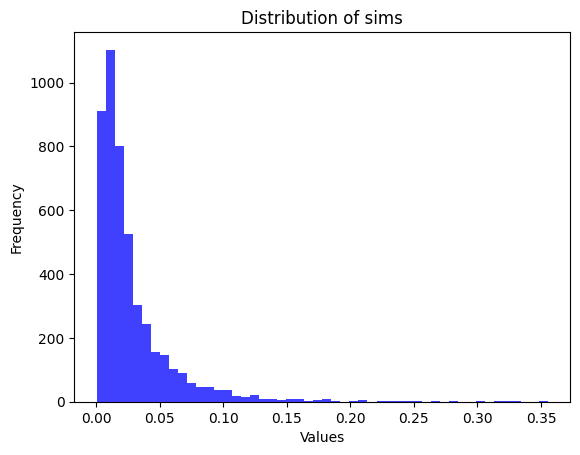

In [62]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.hist(sims, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of sims')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

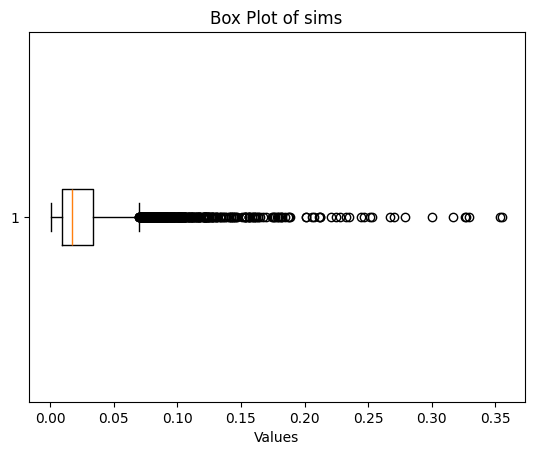

In [63]:
plt.boxplot(sims, vert=False)  # vert=False 使箱形图水平显示
plt.title('Box Plot of sims')
plt.xlabel('Values')
plt.show()

In [64]:
import numpy as np

# 假设 sims 是你的数据数组
Q1 = np.percentile(sims, 25)
Q2 = np.median(sims)
Q3 = np.percentile(sims, 75)
IQR = Q3 - Q1

# 计算异常值的界限
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# 打印结果
print("第一四分位数(Q1):", Q1)
print("中位数(Q2):", Q2)
print("第三四分位数(Q3):", Q3)
print("四分位距(IQR):", IQR)
print("下触须界限:", lower_fence)
print("上触须界限:", upper_fence)


第一四分位数(Q1): 0.009386032819747925
中位数(Q2): 0.017434478
第三四分位数(Q3): 0.033541515469551086
四分位距(IQR): 0.02415548264980316
下触须界限: -0.026847191154956818
上触须界限: 0.06977473944425583


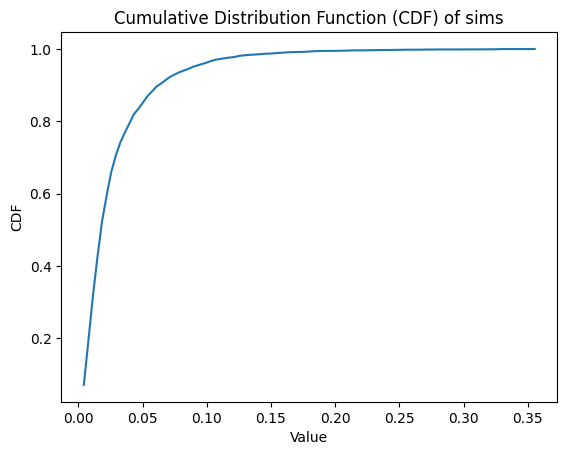

In [65]:
# 计算累积分布函数
hist, bin_edges = np.histogram(sims, bins=100, density=True)
cdf = np.cumsum(hist * np.diff(bin_edges))

# 绘制CDF图
plt.plot(bin_edges[1:], cdf)
plt.title('Cumulative Distribution Function (CDF) of sims')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.show()

In [70]:
def map_scores(value):
    Q1 = 0.009386032819747925
    Q2 = 0.017434478
    Q3 = 0.033541515469551086
    upper_fence = 0.06977473944425583
    if value >= upper_fence:
        return 98
    elif value == 0:
        return 65
    elif value == Q1:
        return 75
    elif value == Q2:
        return 85
    elif value == Q3:
        return 90
    else:
        if value < Q1:
            # 在0到Q1之间线性插值映射到65-75
            return 65 + (75 - 65) * (value / Q1)
        elif value < Q2:
            # 在Q1到Q2之间线性插值映射到75-85
            return 75 + (85 - 75) * ((value - Q1) / (Q2 - Q1))
        elif value < Q3:
            # 在Q2到Q3之间线性插值映射到85-90
            return 85 + (90 - 85) * ((value - Q2) / (Q3 - Q2))
        else:
            # 在Q3到上触须之间线性插值映射到90-98
            return 90 + (98 - 90) * ((value - Q3) / (upper_fence - Q3))

# 假设sims是原始数组，将其映射到新的分数
mapped_scores = np.vectorize(map_scores)(sims)

for i, w in enumerate(list(word_top)[150:200]):
    print(w, mapped_scores[i])

机器视觉 69.05470196194231
窗 82.96083107149866
轻 69.094963215566
学术研究 66.27324626995996
西汉 71.26233953445544
施工 89.15037120984343
白族 82.05133284702345
供给侧 90.95506011444044
耐 85.2782801767005
汉魏六朝 77.4658503078934
态势 86.41837777829174
血 75.4731153332025
文化传播 67.7850118910406
二氧 88.44934199875107
友好 93.95566898019202
并购 72.34653572233705
快速 74.56884261596542
1912 85.71803316603835
公众参与 88.62959502278142
酸 70.08771428480709
文明 89.86966255753174
建 73.40863267321389
难点 76.16873595224783
辽宁 91.90932074558397
线上线下 68.8364402447427
差异化 87.09866549483081
民族 88.00120729930384
人工智能时代 91.04652363565029
2016 67.24326306665016
治理研究 87.02689363276824
党 79.56626465872525
绿色 98.0
定价研究 70.41850430077824
立体 91.43835599255708
一款 70.48727865042245
摄影 79.65661461669771
前景 71.2106476410017
武陵山片区 93.76812270094575
磷 89.04621967296528
团队 85.30988273932049
规避 73.71776797706252
译本 89.96591345375488
测算 70.30032418564629
乳腺癌 71.11380472021922
料 68.53613193498506
化解 78.8466494606774
动作 98.0
肠道菌群 83.74613513243304
补 77